# Extreme Events EDA

Goals: explore how extreme climate events affect GPP and how plants memorize extreme events and change response moving forward

Status: I've only run on ~50 of the sites, my local environment get memory issues that I need to figure out in order to collect all of this info

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import zscore, skew
from sklearn.cluster import KMeans
import warnings 
import os.path
import io
import sys
from tqdm import tqdm
from datetime import date
sys.path.append('../tools')
from CloudIO.AzStorageClient import AzStorageClient

today = str(date.today())
warnings.filterwarnings('ignore') 

# Set paths
wd = '/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling/'
data = wd + 'data/datasets/'
hh_data = data + 'half_hourly/'
code = wd + 'code/src/'
eda_img = code + 'EDA/images/'

#### Init Azure Connection

In [3]:
# # Mac or Windows
# pc = "mac"
# if pc == "windows":
#     slash = "\\"
# else:
#     slash = "/"

# # Define Constants
# root_dir =  os.path.abspath(os.getcwd()+f"..{slash}..{slash}..{slash}..{slash}")
# tmp_dir = root_dir + f"{slash}.tmp"
# cred_dir = root_dir + f"{slash}.cred"
# az_cred_file = cred_dir + f'{slash}azblobcred.json'

# if not (os.path.exists(tmp_dir)):
#     os.mkdir(tmp_dir)

# # Initialize Azure Storage Client
# azStorageClient = AzStorageClient(az_cred_file)

# # List blobs names under the container "data_full_half_hourly"
# container_name = 'full-half-hourly-raw'
# blob_name_list = azStorageClient.listBlobs(container_name)
# for i, blob in enumerate(blob_name_list):
#     print(f'{i:3} {blob.name}')
#     if i > 4:
#         break

### Define Functions

In [4]:
# Parse start time
def parse_timestamp(timestamp):
    date = timestamp[0:8]
    year = int(timestamp[0:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])
    hour = int(timestamp[8:10])
    mins = int(timestamp[10:12])

    return date, year, month, day, hour, mins
    

def define_season_tod(df, predictors, target='GPP_NT_VUT_REF'):
    # Season indicator
    df['SEASON'] = ''
    df['SEASON_NUM'] = 1
    df.loc[df['MONTH'].isin([12, 1, 2]), 'SEASON'] = 'WINTER'
    df.loc[df['MONTH'].isin([3, 4, 5]), 'SEASON'] = 'SPRING'
    df.loc[df['MONTH'].isin([6, 7, 8]), 'SEASON'] = 'SUMMER'
    df.loc[df['MONTH'].isin([9, 10, 11]), 'SEASON'] = 'FALL'
    df.loc[df['MONTH'].isin([12, 1, 2]), 'SEASON_NUM'] = 1
    df.loc[df['MONTH'].isin([3, 4, 5]), 'SEASON_NUM'] = 2
    df.loc[df['MONTH'].isin([6, 7, 8]), 'SEASON_NUM'] = 3
    df.loc[df['MONTH'].isin([9, 10, 11]), 'SEASON_NUM'] = 4

    # 6-Hour TOD indicator
    df['TOD_GROUP'] = ''
    df.loc[df['HOUR'].isin(list(range(0, 6))), 'TOD_GROUP'] = '1'
    df.loc[df['HOUR'].isin(list(range(6, 12))), 'TOD_GROUP'] = '2'
    df.loc[df['HOUR'].isin(list(range(12, 18))), 'TOD_GROUP'] = '3'
    df.loc[df['HOUR'].isin(list(range(18, 24))), 'TOD_GROUP'] = '4'

    # Merge to define season-TOD groups
    df['SEASON_TOD'] = df['SEASON'] + '_' + df['TOD_GROUP']

    # Create GPP_extreme indicator to fill in later
    for feat in predictors:
        df['Z_' + feat] = 0
    df['Z_' + target] = 0
    df['EXT_IND_' + target] = 0

    return df


def find_extremes(group_by, group, predictors, target, df):
    # Subset df to SEASON group
    subset = df[df[group_by]==group].copy()

    # Get z-scores for each record within ST group context
    for feat in predictors:
        arr = subset[feat]
        z = arr.copy()
        z[~np.isnan(arr)] = zscore(arr[~np.isnan(arr)]) # handle NANs
        df.loc[list(z.index), 'Z_' + feat] = z

    # Get GPP z-scores and identify extreme events
    arr = subset[target]
    z = arr.copy()
    z[~np.isnan(arr)] = zscore(arr[~np.isnan(arr)]) # handle NANs
    df.loc[list(z.index), 'Z_' + target] = z
    outlier_inds = z[np.abs(z) >= 3].index

    # Write GPP outliers to extreme_indicator var
    if len(outlier_inds) > 0:
        df.loc[list(outlier_inds), 'EXT_IND_' + target] = 1

    return df


def find_n_clusters(df, sse_reduction_thresh = 0.125, plot=False):
    SSE = []
    for n_clusters in range(2, 20, 2):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
        kmeans.fit(df)
        SSE.append(kmeans.inertia_)

    # Plot elbow curve
    if plot:
        plt.figure(figsize=(5, 3))
        plt.plot(range(2, 20, 2), SSE)
        plt.xlabel("Number of Clusters")
        plt.ylabel("Sum of Squared Errors (SSE)")
        plt.title("Elbow Curve")
        plt.show()

    # Determine num clusters based on SSE reduction threshold
    sse_decrease = 1- np.array(SSE)/np.roll(np.array(SSE), 1)
    sse_decrease[0] = 1.0
    try:
        n_clusters = np.where(sse_decrease < sse_reduction_thresh)[0][0] + 1
    except:
        n_clusters = 3
    if n_clusters < 3:
        n_clusters = 3

    return n_clusters


def k_means(df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(df)
    
    return kmeans.cluster_centers_, kmeans.labels_

### Loop through sites, extract metadata -> moved to .py and .sh runs

In [5]:
# ## Create Metadata for each site
# # Init df
# try:
#     global_events = pd.read_csv(f'{data}site_metadata_ext_events_EDA_{today}.csv')
#     print(f"Length of pre-loaded global sites: {len(global_events)}")
# except:
#     global_events = pd.DataFrame(columns=['SITE_ID'])

# # Load site file
# for i, blob in tqdm(enumerate(blob_name_list)):
#     # Download blob from Azure
#     blob_name = blob.name
#     site_name = blob_name.split('_')[-1][:-4]
#     if site_name in global_events['SITE_ID'].values:
#         continue
#     else:
#         site_meta = {}
#         fname = azStorageClient.downloadBlob(container_name, blob_name)
#         site_df = pd.read_csv(io.StringIO(fname.decode('utf-8')))
#         site_meta['SITE_ID'] = site_name

#         # Drop NA
#         site_df.dropna(subset=['GPP_NT_VUT_REF'], inplace=True)
#         site_meta['HH_RECORDS'] = int(len(site_df))
#         if len(site_df) < 2*24*100:
#             global_events = global_events.append(site_meta, ignore_index=True)
#             break
#         else:

#             # Parse timestamps
#             site_df[['DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINS']] = \
#             site_df['TIMESTAMP_START'].astype(str).apply(parse_timestamp).apply(pd.Series)
#             predictors = ['TA_ERA', 'P_ERA', 'P_ERA_ROLL7', 'P_ERA_ROLL30', 'VPD_ERA',
#                     'SW_IN_ERA', 'LW_IN_ERA', 'PA_ERA', 'NDVI', 'EVI', 'NIRv'] # <--- CHECK IF OTHERS SHOULD BE INCLUDED
#             target = 'GPP_NT_VUT_REF'
#             site_df = define_season_tod(site_df, predictors, target)

#             # Feature Creation
#             site_df['P_ERA_ROLL7'] = site_df['P_ERA'].rolling(7, min_periods=1).sum()
#             site_df['P_ERA_ROLL30'] = site_df['P_ERA'].rolling(30, min_periods=1).sum()

#             # Get extreme events by season
#             group_by = 'SEASON'
#             groups = site_df[group_by].unique()
#             for group in groups:
#                 site_df = find_extremes(group_by, group, predictors, target, site_df)

#             # Get % of positive, negative events
#             total_events = len(site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1])
#             pos_count = len(site_df.loc[(site_df['EXT_IND_GPP_NT_VUT_REF']==1) & (site_df['Z_GPP_NT_VUT_REF'] >= 3), ])
#             site_meta['POS_EVENT_RATE'] = round(pos_count/total_events, 3)
#             site_meta['NEG_EVENT_RATE'] = round((total_events - pos_count)/total_events, 3)

#             # Get avg num of days with extreme events per year
#             event_days = len(site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, 'DATE'].unique())
#             record_years = len(site_df)/(2*24*365)
#             site_meta['EXT_EVENTS_PER_YEAR'] = event_days/record_years
#             site_meta['EXT_EVENTS_PER_DAY'] = site_df.groupby('DATE')['EXT_IND_GPP_NT_VUT_REF'].sum().mean()

#             # Get number of clusters for site
#             season_dummies = pd.get_dummies(site_df['SEASON'])
#             site_df = pd.concat([site_df, season_dummies], axis=1)
#             clust_feats = list(season_dummies.columns) + ['Z_' + i for i in predictors] + ['Z_GPP_NT_VUT_REF']
#             ext_gpp = site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, clust_feats].copy()
#             ext_gpp = ext_gpp.dropna(how='any')
#             n_clusters = find_n_clusters(ext_gpp)
#             site_meta['N_CLUSTERS'] = n_clusters

#             # Analyze Episodes (instead of indiv events)
#             episodes = site_df.loc[site_df['EXT_IND_GPP_NT_VUT_REF']==1, ['DATE', 'EXT_IND_GPP_NT_VUT_REF']].drop_duplicates().reset_index(drop=True)
#             episodes['DATE'] = episodes['DATE'].astype(int)
#             episodes['BEGIN_EP'] = (episodes['DATE'] - episodes['DATE'].shift(1) > 1).astype(int)
#             episodes.loc[0, 'BEGIN_EP'] = 1
#             episodes['EP_NUM'] = episodes['BEGIN_EP'].cumsum()
#             site_meta['NUM_EPISODES_PER_YR'] = episodes['BEGIN_EP'].sum()/record_years

#             # What is average duration of episode?
#             episodes['DATE'] = episodes['DATE'].astype(int)
#             ep_time = pd.DataFrame(episodes.groupby('EP_NUM').agg({'DATE': ['min', 'max']}))
#             ep_time.columns = ['START', 'END']
#             ep_time['DURATION'] = ep_time['END'] - ep_time['START'] + 1

#             # Save summary metrics
#             site_meta['EP_AVG_DURATION'] = ep_time['DURATION'].mean()
#             site_meta['EP_MAX_DURATION'] = ep_time['DURATION'].max()

#             # Load df and write out site record
#             global_events = global_events.append(site_meta, ignore_index=True)

#         if i%30==0:
#             print(f"Saving csv: {len(global_events)}")
#             global_events.to_csv(f'{data}site_metadata_ext_events_EDA_{today}.csv', index=False)

#     if i > 8:
#         break

# # Write out at end
# global_events.to_csv(f'{data}site_metadata_ext_events_EDA_{today}.csv', index=False)

In [7]:
global_events = pd.read_csv(f'{data}site_metadata_ext_events_EDA_2023-02-07.csv')
global_events.head()

,SITE_ID,HH_RECORDS,POS_EVENT_RATE,NEG_EVENT_RATE,EXT_EVENTS_PER_YEAR,EXT_EVENTS_PER_DAY,N_CLUSTERS,NUM_EPISODES_PER_YR,EP_AVG_DURATION,EP_MAX_DURATION
0,AU-Cum,37728.0,0.860,0.140,88.231552,0.380407,5.0,55.260814,1.596639,6.0
1,AU-DaP,92544.0,0.907,0.093,65.692427,0.975622,5.0,20.067427,3.273585,23.0
2,AU-DaS,115392.0,0.905,0.095,58.150998,0.356073,5.0,32.795341,1.773148,23.0
3,AU-Dry,80688.0,0.920,0.080,48.854848,0.267698,5.0,27.358715,1.785714,15.0
4,AU-Emr,40896.0,0.972,0.028,80.539906,1.085681,5.0,28.703052,2.805970,20.0


### Analysis of Metadata

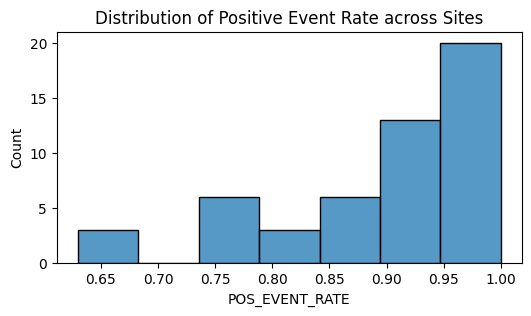

In [8]:
## Distribution of Pos vs Neg Event Rate
plt.figure(figsize=(6, 3))
plt.title('Distribution of Positive Event Rate across Sites')
sns.histplot(global_events['POS_EVENT_RATE'])
plt.show()

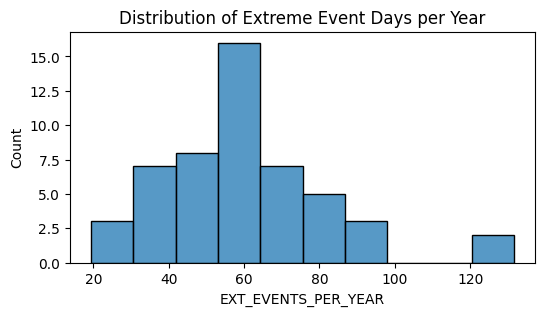

In [9]:
## Distribution of Events per Year
# There should be the same amount of extreme events per year (given Z score logic)
# .. so having less days with extreme events means that the site was hit harder (for more timestamps) each day
# .. and the impact was more intense/dense than others that were more distributed
plt.figure(figsize=(6, 3))
plt.title('Distribution of Extreme Event Days per Year')
sns.histplot(global_events['EXT_EVENTS_PER_YEAR'])
plt.show()

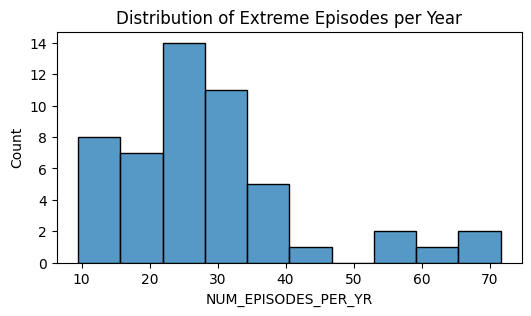

In [10]:
## Distribution of Episodes per Year
plt.figure(figsize=(6, 3))
plt.title('Distribution of Extreme Episodes per Year')
sns.histplot(global_events['NUM_EPISODES_PER_YR'])
plt.show()

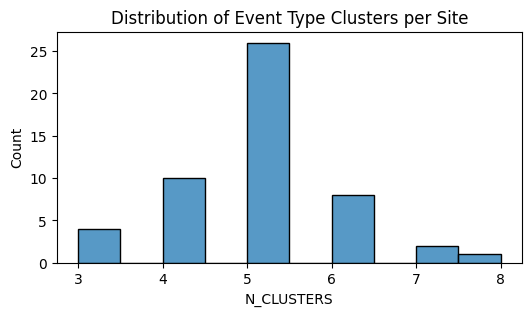

In [11]:
## Distribution of Clusters per site
plt.figure(figsize=(6, 3))
plt.title('Distribution of Event Type Clusters per Site')
sns.histplot(global_events['N_CLUSTERS'].astype(int))
plt.show()